In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid') # sns에 흰색 그리드 유지
import missingno # 결측치 시각화

# KFold (교차 검증을 사용하기 위해)
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# 학습 데이터와 검증 데이터로 나누는 함수
from sklearn.model_selection import train_test_split

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 평가 함수
from sklearn.metrics import accuracy_score

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier


# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import  XGBRegressor

# 머신러닝 알고리즘 - 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift

# 머신러닝 알고리즘 - 차원축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 다중분류를 위한 원핫 인코더
from keras.utils import to_categorical

# 학습 자동 중단
from keras.callbacks import EarlyStopping

# 모델 저장
from keras.callbacks import ModelCheckpoint

# 저장된 딥러닝 모델 불러오기
from keras.models import load_model

# 딥러닝
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Reshape
from keras.layers import UpSampling2D
from keras.layers import Input
from keras.models import Model

# 자연어 처리
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

# 저장
import pickle

# 시간 모듈
import time

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우용
# plt.rcParams['font.family'] = 'AppleGothic'   # 맥용
plt.rcParams['font.size'] = 10                 # 폰트 크기
plt.rcParams['figure.figsize'] = 10,8          # 그래프 크기
plt.rcParams['axes.unicode_minus'] = False     # - 기호 깨짐 방지


# 경고 메시지가 안나오게 하기
import warnings
warnings.filterwarnings('ignore')

# gpu 사용 초기화 및 할당
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
# MNIST
from keras.datasets import mnist

In [3]:
# 시드 설정
np.random.seed(3)
tf.random.set_seed(3)

In [4]:
# 생성자 모델을 생성
generator = Sequential()

# 첫번째 은닉층(입력층 포함)
# 126은 임의로 정한 노드의 개수
# input_dim = 100차원 크기의 랜덤 벡터를 준비해라.
# 7*7 : 최초로 생성되는 이미지의 크기
# UpSampling2D를 두번 사용했으므로 7 x 7 -> 14 x 14 -> 28 x 28
generator.add(Dense(128*7*7, input_dim =100, activation=LeakyReLU(0.2)))
# 정규분포로 만드는 배치 정규화 
generator.add(BatchNormalization())
# 컨볼루션 레이어(CNN)이 작업할 수 있는 형태로 데이터를 변환한다.
generator.add(Reshape((7,7,128)))
# 두배로 증가
generator.add(UpSampling2D())
# CNN 학습 (padding='same'으로 설정하여 CNN 학습시 작아지는것을 방지)
generator.add(Conv2D(64, kernel_size=5, padding='same'))

# 배치정규화
generator.add(BatchNormalization())
# 활성화 함수
generator.add(Activation(LeakyReLU(0.2)))
# 두배로 증가
generator.add(UpSampling2D())
# CNN 학습
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [5]:
# 판별자
discriminator = Sequential()
# CNN 학습
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

# CNN 학습
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

# 예측 결과 추출을 위해 1차원으로 변환한다.
discriminator.add(Flatten())
# 출력층
discriminator.add(Dense(1, activation='sigmoid'))

In [6]:
# 판별자 컴파일
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
# 학습을 방지한다.
discriminator.trainable=False

In [8]:
# 생성자와 판별자를 연결시키는 GAN 모델을 생성한다.
# 생성자
# 임의의 벡터 100개를 생성
ginput = Input(shape=(100,))
# 판별자
dis_output = discriminator(generator(ginput))

In [9]:
# GAN 모델 생성
gen = Model(ginput, dis_output)

In [11]:
gen.compile(loss='binary_crossentropy', optimizer='adam')
gen.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [17]:
# MNIST 데이터 불러오기
# GAN은 주어진 이미지를 학습해 새로운 이미지를 만드는 것이므로
# 이미지만 필요로 한다.
(X_train, _),(_,_) = mnist.load_data()

# 하나의 벡터로 변환
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

# 학습용 데이터 배치 정규화 (-1 ~ 1 사이로 맞추는 작업)
X_train = (X_train - 127.5) / 127.5

In [18]:
# 잘 만들어진 이미지 정보를 가질 행렬
true = np.ones((32,1))
# 가짜 이미지 정보를 가질 행렬
fake = np.zeros((32,1))

epoch : 0, d_loss : 0.5117188394069672, g_loss : 1.6346112489700317
epoch : 1, d_loss : 0.47903871536254883, g_loss : 1.4709854125976562
epoch : 2, d_loss : 0.5479501038789749, g_loss : 1.772230863571167
epoch : 3, d_loss : 0.48802846670150757, g_loss : 1.5580527782440186
epoch : 4, d_loss : 0.5156557857990265, g_loss : 1.5620667934417725
epoch : 5, d_loss : 0.41021858155727386, g_loss : 1.720564842224121
epoch : 6, d_loss : 0.4120951443910599, g_loss : 1.4729604721069336
epoch : 7, d_loss : 0.4166013300418854, g_loss : 1.5758469104766846
epoch : 8, d_loss : 0.6193017363548279, g_loss : 1.5908316373825073
epoch : 9, d_loss : 0.432442307472229, g_loss : 1.59657883644104
epoch : 10, d_loss : 0.3636922836303711, g_loss : 1.7591748237609863
epoch : 11, d_loss : 0.5498520135879517, g_loss : 1.555573582649231
epoch : 12, d_loss : 0.5784316211938858, g_loss : 1.4810771942138672
epoch : 13, d_loss : 0.3952223211526871, g_loss : 1.403731107711792
epoch : 14, d_loss : 0.4033074527978897, g_loss 

epoch : 121, d_loss : 0.5366425067186356, g_loss : 1.346894383430481
epoch : 122, d_loss : 0.648907333612442, g_loss : 1.3862724304199219
epoch : 123, d_loss : 0.5635684132575989, g_loss : 1.3115425109863281
epoch : 124, d_loss : 0.5569999068975449, g_loss : 1.3465527296066284
epoch : 125, d_loss : 0.4300743341445923, g_loss : 1.766143798828125
epoch : 126, d_loss : 0.4061412960290909, g_loss : 1.9688167572021484
epoch : 127, d_loss : 0.43432754278182983, g_loss : 1.6780798435211182
epoch : 128, d_loss : 0.5812915861606598, g_loss : 1.5827295780181885
epoch : 129, d_loss : 0.5592467188835144, g_loss : 1.302160620689392
epoch : 130, d_loss : 0.36332985758781433, g_loss : 1.5895769596099854
epoch : 131, d_loss : 0.5348824560642242, g_loss : 1.5831243991851807
epoch : 132, d_loss : 0.4512864053249359, g_loss : 1.5873992443084717
epoch : 133, d_loss : 0.4486619681119919, g_loss : 1.867549180984497
epoch : 134, d_loss : 0.4864256680011749, g_loss : 2.15786075592041
epoch : 135, d_loss : 0.6

epoch : 238, d_loss : 0.610046923160553, g_loss : 1.7184064388275146
epoch : 239, d_loss : 0.4953220933675766, g_loss : 1.644222378730774
epoch : 240, d_loss : 0.42450687289237976, g_loss : 1.3742380142211914
epoch : 241, d_loss : 0.6394444704055786, g_loss : 1.4069294929504395
epoch : 242, d_loss : 0.6861775815486908, g_loss : 1.3781890869140625
epoch : 243, d_loss : 0.5650639235973358, g_loss : 1.529249906539917
epoch : 244, d_loss : 0.3763163089752197, g_loss : 1.7774349451065063
epoch : 245, d_loss : 0.4261678457260132, g_loss : 1.6207187175750732
epoch : 246, d_loss : 0.4403954893350601, g_loss : 1.9834046363830566
epoch : 247, d_loss : 0.5572729110717773, g_loss : 1.1190576553344727
epoch : 248, d_loss : 0.4423649311065674, g_loss : 1.5892137289047241
epoch : 249, d_loss : 0.548555850982666, g_loss : 1.3142151832580566
epoch : 250, d_loss : 0.5396251976490021, g_loss : 1.4955382347106934
epoch : 251, d_loss : 0.584673285484314, g_loss : 1.593741536140442
epoch : 252, d_loss : 0.5

epoch : 358, d_loss : 0.39074642956256866, g_loss : 1.809276819229126
epoch : 359, d_loss : 0.5074151009321213, g_loss : 1.9394073486328125
epoch : 360, d_loss : 0.364384263753891, g_loss : 1.9656240940093994
epoch : 361, d_loss : 0.4551861882209778, g_loss : 1.9354264736175537
epoch : 362, d_loss : 0.6760115921497345, g_loss : 1.6550966501235962
epoch : 363, d_loss : 0.5531457811594009, g_loss : 1.6170461177825928
epoch : 364, d_loss : 0.3969229459762573, g_loss : 2.044863224029541
epoch : 365, d_loss : 0.5650778710842133, g_loss : 1.797908902168274
epoch : 366, d_loss : 0.4749283045530319, g_loss : 1.452676773071289
epoch : 367, d_loss : 0.3734019547700882, g_loss : 1.627375841140747
epoch : 368, d_loss : 0.49121953547000885, g_loss : 1.6308295726776123
epoch : 369, d_loss : 0.4781794846057892, g_loss : 1.3217236995697021
epoch : 370, d_loss : 0.4336286634206772, g_loss : 1.710822343826294
epoch : 371, d_loss : 0.49777308106422424, g_loss : 1.6620101928710938
epoch : 372, d_loss : 0.

epoch : 478, d_loss : 0.41325171291828156, g_loss : 2.1668951511383057
epoch : 479, d_loss : 0.4320347160100937, g_loss : 2.2914986610412598
epoch : 480, d_loss : 0.4107123911380768, g_loss : 1.9555320739746094
epoch : 481, d_loss : 0.597724974155426, g_loss : 1.5881818532943726
epoch : 482, d_loss : 0.5326956808567047, g_loss : 1.7651002407073975
epoch : 483, d_loss : 0.5850151181221008, g_loss : 1.1338791847229004
epoch : 484, d_loss : 0.386582612991333, g_loss : 1.7814098596572876
epoch : 485, d_loss : 0.4576851427555084, g_loss : 2.1295602321624756
epoch : 486, d_loss : 0.4093276262283325, g_loss : 1.9870996475219727
epoch : 487, d_loss : 0.5081148594617844, g_loss : 2.0247204303741455
epoch : 488, d_loss : 0.39222264289855957, g_loss : 1.6282652616500854
epoch : 489, d_loss : 0.4449879825115204, g_loss : 1.4690966606140137
epoch : 490, d_loss : 0.493894100189209, g_loss : 1.8542332649230957
epoch : 491, d_loss : 0.5052388310432434, g_loss : 1.7248212099075317
epoch : 492, d_loss :

epoch : 598, d_loss : 0.4598798155784607, g_loss : 1.7317124605178833
epoch : 599, d_loss : 0.39414556324481964, g_loss : 1.6199698448181152
epoch : 600, d_loss : 0.4298592060804367, g_loss : 2.136737108230591
epoch : 601, d_loss : 0.47808021306991577, g_loss : 1.640458106994629
epoch : 602, d_loss : 0.4254603385925293, g_loss : 2.0853703022003174
epoch : 603, d_loss : 0.559393972158432, g_loss : 1.6232424974441528
epoch : 604, d_loss : 0.45423945784568787, g_loss : 1.9006679058074951
epoch : 605, d_loss : 0.568916916847229, g_loss : 1.7518905401229858
epoch : 606, d_loss : 0.5120248794555664, g_loss : 1.6795463562011719
epoch : 607, d_loss : 0.44223493337631226, g_loss : 1.3779988288879395
epoch : 608, d_loss : 0.6501218676567078, g_loss : 1.280519723892212
epoch : 609, d_loss : 0.5689466893672943, g_loss : 1.458064317703247
epoch : 610, d_loss : 0.5497365891933441, g_loss : 1.571936845779419
epoch : 611, d_loss : 0.513086199760437, g_loss : 1.8373832702636719
epoch : 612, d_loss : 0.

epoch : 716, d_loss : 0.4983286112546921, g_loss : 2.1872169971466064
epoch : 717, d_loss : 0.6782959550619125, g_loss : 1.380464792251587
epoch : 718, d_loss : 0.38019657135009766, g_loss : 1.4056118726730347
epoch : 719, d_loss : 0.5695887506008148, g_loss : 0.9805002212524414
epoch : 720, d_loss : 0.4686261862516403, g_loss : 1.5499119758605957
epoch : 721, d_loss : 0.47529473900794983, g_loss : 1.3811081647872925
epoch : 722, d_loss : 0.40010198950767517, g_loss : 2.101633071899414
epoch : 723, d_loss : 0.5657601356506348, g_loss : 1.820489764213562
epoch : 724, d_loss : 0.5301724374294281, g_loss : 1.8012208938598633
epoch : 725, d_loss : 0.5251132845878601, g_loss : 1.9060288667678833
epoch : 726, d_loss : 0.5009678900241852, g_loss : 2.123277187347412
epoch : 727, d_loss : 0.47402434051036835, g_loss : 1.831973671913147
epoch : 728, d_loss : 0.46526239812374115, g_loss : 1.642907977104187
epoch : 729, d_loss : 0.466810941696167, g_loss : 1.6860960721969604
epoch : 730, d_loss : 

epoch : 837, d_loss : 0.39413902163505554, g_loss : 1.6677799224853516
epoch : 838, d_loss : 0.4871752858161926, g_loss : 1.990557074546814
epoch : 839, d_loss : 0.5261120200157166, g_loss : 1.9643025398254395
epoch : 840, d_loss : 0.3861370086669922, g_loss : 2.0025038719177246
epoch : 841, d_loss : 0.622582346200943, g_loss : 1.2746877670288086
epoch : 842, d_loss : 0.6469938457012177, g_loss : 1.3256584405899048
epoch : 843, d_loss : 0.4879162460565567, g_loss : 1.8966423273086548
epoch : 844, d_loss : 0.5031042993068695, g_loss : 1.5732080936431885
epoch : 845, d_loss : 0.40722933411598206, g_loss : 1.374941110610962
epoch : 846, d_loss : 0.4765474498271942, g_loss : 1.5468108654022217
epoch : 847, d_loss : 0.4417668431997299, g_loss : 1.4410531520843506
epoch : 848, d_loss : 0.5518597066402435, g_loss : 1.4679350852966309
epoch : 849, d_loss : 0.49114370346069336, g_loss : 1.5239660739898682
epoch : 850, d_loss : 0.6117947995662689, g_loss : 1.4742273092269897
epoch : 851, d_loss 

epoch : 958, d_loss : 0.5107427835464478, g_loss : 1.7491483688354492
epoch : 959, d_loss : 0.5116266310214996, g_loss : 1.5571660995483398
epoch : 960, d_loss : 0.637857049703598, g_loss : 1.419975757598877
epoch : 961, d_loss : 0.68451327085495, g_loss : 1.4543981552124023
epoch : 962, d_loss : 0.4521276354789734, g_loss : 1.4189152717590332
epoch : 963, d_loss : 0.4052427113056183, g_loss : 1.6348422765731812
epoch : 964, d_loss : 0.516520544886589, g_loss : 1.782177448272705
epoch : 965, d_loss : 0.4038822501897812, g_loss : 1.654531478881836
epoch : 966, d_loss : 0.5916461944580078, g_loss : 1.9859519004821777
epoch : 967, d_loss : 0.6282355934381485, g_loss : 1.7603479623794556
epoch : 968, d_loss : 0.47410231828689575, g_loss : 1.7553350925445557
epoch : 969, d_loss : 0.6209472417831421, g_loss : 1.3908071517944336
epoch : 970, d_loss : 0.42593519389629364, g_loss : 1.28987717628479
epoch : 971, d_loss : 0.4891635775566101, g_loss : 1.1735076904296875
epoch : 972, d_loss : 0.436

epoch : 1077, d_loss : 0.5746096074581146, g_loss : 1.6848609447479248
epoch : 1078, d_loss : 0.43987326323986053, g_loss : 1.839717149734497
epoch : 1079, d_loss : 0.5181435197591782, g_loss : 1.2634985446929932
epoch : 1080, d_loss : 0.5858950316905975, g_loss : 1.6071031093597412
epoch : 1081, d_loss : 0.6651942729949951, g_loss : 1.5335667133331299
epoch : 1082, d_loss : 0.5351852476596832, g_loss : 1.7254589796066284
epoch : 1083, d_loss : 0.689436137676239, g_loss : 1.3916740417480469
epoch : 1084, d_loss : 0.47516798973083496, g_loss : 1.6087003946304321
epoch : 1085, d_loss : 0.5491854399442673, g_loss : 1.6705878973007202
epoch : 1086, d_loss : 0.5572085827589035, g_loss : 1.766875147819519
epoch : 1087, d_loss : 0.5591020584106445, g_loss : 1.323665738105774
epoch : 1088, d_loss : 0.5220553576946259, g_loss : 1.644822359085083
epoch : 1089, d_loss : 0.4735070765018463, g_loss : 1.657958745956421
epoch : 1090, d_loss : 0.5030758082866669, g_loss : 2.0062010288238525
epoch : 10

epoch : 1196, d_loss : 0.44708195328712463, g_loss : 1.5765433311462402
epoch : 1197, d_loss : 0.48271918296813965, g_loss : 1.911780834197998
epoch : 1198, d_loss : 0.5955289304256439, g_loss : 1.7353683710098267
epoch : 1199, d_loss : 0.5151123106479645, g_loss : 1.4183740615844727
epoch : 1200, d_loss : 0.48141977190971375, g_loss : 1.194526195526123
epoch : 1201, d_loss : 0.41823045909404755, g_loss : 1.7891244888305664
epoch : 1202, d_loss : 0.43480661511421204, g_loss : 1.5811963081359863
epoch : 1203, d_loss : 0.5269342064857483, g_loss : 1.4343814849853516
epoch : 1204, d_loss : 0.45386847853660583, g_loss : 1.4062671661376953
epoch : 1205, d_loss : 0.6265235245227814, g_loss : 1.2887306213378906
epoch : 1206, d_loss : 0.4822479635477066, g_loss : 1.7357507944107056
epoch : 1207, d_loss : 0.5098004043102264, g_loss : 1.794100284576416
epoch : 1208, d_loss : 0.5835211277008057, g_loss : 1.661202073097229
epoch : 1209, d_loss : 0.5114631205797195, g_loss : 2.0715932846069336
epoc

epoch : 1314, d_loss : 0.6220985949039459, g_loss : 1.560150384902954
epoch : 1315, d_loss : 0.462450310587883, g_loss : 1.7148213386535645
epoch : 1316, d_loss : 0.4710604250431061, g_loss : 1.665663719177246
epoch : 1317, d_loss : 0.5260584056377411, g_loss : 1.5639779567718506
epoch : 1318, d_loss : 0.5524619221687317, g_loss : 1.77332603931427
epoch : 1319, d_loss : 0.5283304452896118, g_loss : 1.310904860496521
epoch : 1320, d_loss : 0.6235742270946503, g_loss : 1.430396318435669
epoch : 1321, d_loss : 0.6344059407711029, g_loss : 1.3059343099594116
epoch : 1322, d_loss : 0.5096719563007355, g_loss : 1.3155096769332886
epoch : 1323, d_loss : 0.4598566144704819, g_loss : 1.3491151332855225
epoch : 1324, d_loss : 0.6697884798049927, g_loss : 1.679702877998352
epoch : 1325, d_loss : 0.5892144739627838, g_loss : 1.5602912902832031
epoch : 1326, d_loss : 0.600458949804306, g_loss : 1.7818541526794434
epoch : 1327, d_loss : 0.5454869419336319, g_loss : 1.5594379901885986
epoch : 1328, d

epoch : 1431, d_loss : 0.4214613288640976, g_loss : 1.7239058017730713
epoch : 1432, d_loss : 0.5765653252601624, g_loss : 2.3096675872802734
epoch : 1433, d_loss : 0.57015061378479, g_loss : 1.8764936923980713
epoch : 1434, d_loss : 0.4408821761608124, g_loss : 1.5206961631774902
epoch : 1435, d_loss : 0.4378338009119034, g_loss : 1.7293752431869507
epoch : 1436, d_loss : 0.43761134147644043, g_loss : 1.8014209270477295
epoch : 1437, d_loss : 0.48100022971630096, g_loss : 2.0441837310791016
epoch : 1438, d_loss : 0.5335414409637451, g_loss : 2.003831386566162
epoch : 1439, d_loss : 0.3699236214160919, g_loss : 1.8851754665374756
epoch : 1440, d_loss : 0.6033929586410522, g_loss : 1.8140556812286377
epoch : 1441, d_loss : 0.6108917891979218, g_loss : 1.7839831113815308
epoch : 1442, d_loss : 0.41120803356170654, g_loss : 1.8382141590118408
epoch : 1443, d_loss : 0.5427520275115967, g_loss : 1.6578911542892456
epoch : 1444, d_loss : 0.5502728223800659, g_loss : 1.6110963821411133
epoch 

epoch : 1546, d_loss : 0.417341485619545, g_loss : 1.831779956817627
epoch : 1547, d_loss : 0.5808499455451965, g_loss : 1.8183636665344238
epoch : 1548, d_loss : 0.4442165344953537, g_loss : 1.6920958757400513
epoch : 1549, d_loss : 0.42871974408626556, g_loss : 1.7749550342559814
epoch : 1550, d_loss : 0.361434206366539, g_loss : 1.738860845565796
epoch : 1551, d_loss : 0.40298357605934143, g_loss : 1.7722634077072144
epoch : 1552, d_loss : 0.3501187264919281, g_loss : 1.7962982654571533
epoch : 1553, d_loss : 0.4391440153121948, g_loss : 1.631211757659912
epoch : 1554, d_loss : 0.41610412299633026, g_loss : 2.002946376800537
epoch : 1555, d_loss : 0.5051634162664413, g_loss : 1.881799578666687
epoch : 1556, d_loss : 0.5672303885221481, g_loss : 2.033529281616211
epoch : 1557, d_loss : 0.5333316177129745, g_loss : 1.4438416957855225
epoch : 1558, d_loss : 0.4190113842487335, g_loss : 1.4843578338623047
epoch : 1559, d_loss : 0.4563906788825989, g_loss : 1.550976037979126
epoch : 1560

epoch : 1662, d_loss : 0.6613591909408569, g_loss : 1.3328514099121094
epoch : 1663, d_loss : 0.6565004289150238, g_loss : 1.4987798929214478
epoch : 1664, d_loss : 0.5038544684648514, g_loss : 1.862647533416748
epoch : 1665, d_loss : 0.540239691734314, g_loss : 1.9257217645645142
epoch : 1666, d_loss : 0.546013593673706, g_loss : 1.8131455183029175
epoch : 1667, d_loss : 0.4267786741256714, g_loss : 1.7813124656677246
epoch : 1668, d_loss : 0.45882080495357513, g_loss : 1.9848428964614868
epoch : 1669, d_loss : 0.42056331038475037, g_loss : 1.7116938829421997
epoch : 1670, d_loss : 0.6052617430686951, g_loss : 2.0788216590881348
epoch : 1671, d_loss : 0.6093339920043945, g_loss : 1.6643465757369995
epoch : 1672, d_loss : 0.5603797733783722, g_loss : 1.7285985946655273
epoch : 1673, d_loss : 0.5670772790908813, g_loss : 1.3491533994674683
epoch : 1674, d_loss : 0.527389332652092, g_loss : 1.7504031658172607
epoch : 1675, d_loss : 0.40894921123981476, g_loss : 1.7583675384521484
epoch :

epoch : 1779, d_loss : 0.5989757180213928, g_loss : 1.3042501211166382
epoch : 1780, d_loss : 0.5497632473707199, g_loss : 1.4829422235488892
epoch : 1781, d_loss : 0.6936825513839722, g_loss : 1.6795556545257568
epoch : 1782, d_loss : 0.5176728367805481, g_loss : 1.5928773880004883
epoch : 1783, d_loss : 0.6131699681282043, g_loss : 1.3076162338256836
epoch : 1784, d_loss : 0.615545928478241, g_loss : 1.6183557510375977
epoch : 1785, d_loss : 0.5672235488891602, g_loss : 1.4207797050476074
epoch : 1786, d_loss : 0.6282069683074951, g_loss : 1.139811635017395
epoch : 1787, d_loss : 0.839240550994873, g_loss : 1.4228789806365967
epoch : 1788, d_loss : 0.548549473285675, g_loss : 1.4181023836135864
epoch : 1789, d_loss : 0.49992015957832336, g_loss : 1.845371961593628
epoch : 1790, d_loss : 0.6440163403749466, g_loss : 1.479039192199707
epoch : 1791, d_loss : 0.5157293975353241, g_loss : 1.4180340766906738
epoch : 1792, d_loss : 0.45342960953712463, g_loss : 1.66695237159729
epoch : 1793

epoch : 1895, d_loss : 0.53435879945755, g_loss : 1.5619474649429321
epoch : 1896, d_loss : 0.5115569233894348, g_loss : 1.6147547960281372
epoch : 1897, d_loss : 0.633426159620285, g_loss : 1.3271390199661255
epoch : 1898, d_loss : 0.43174833059310913, g_loss : 1.435553789138794
epoch : 1899, d_loss : 0.39896371960639954, g_loss : 1.748216152191162
epoch : 1900, d_loss : 0.495454803109169, g_loss : 1.6351191997528076
epoch : 1901, d_loss : 0.6101051419973373, g_loss : 1.336322546005249
epoch : 1902, d_loss : 0.6799812018871307, g_loss : 1.407191276550293
epoch : 1903, d_loss : 0.4106728732585907, g_loss : 1.5186008214950562
epoch : 1904, d_loss : 0.6217544078826904, g_loss : 1.552736759185791
epoch : 1905, d_loss : 0.6579508185386658, g_loss : 1.262547254562378
epoch : 1906, d_loss : 0.4494773596525192, g_loss : 1.8603864908218384
epoch : 1907, d_loss : 0.45054247975349426, g_loss : 1.9824652671813965
epoch : 1908, d_loss : 0.3703741282224655, g_loss : 1.7629692554473877
epoch : 1909,

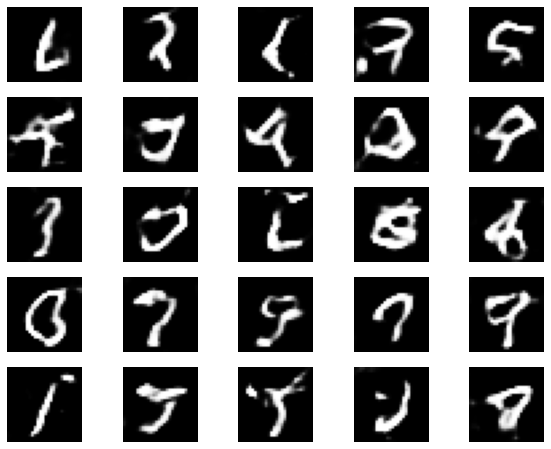

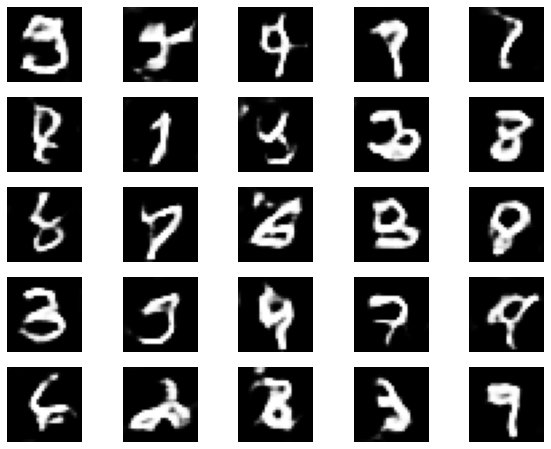

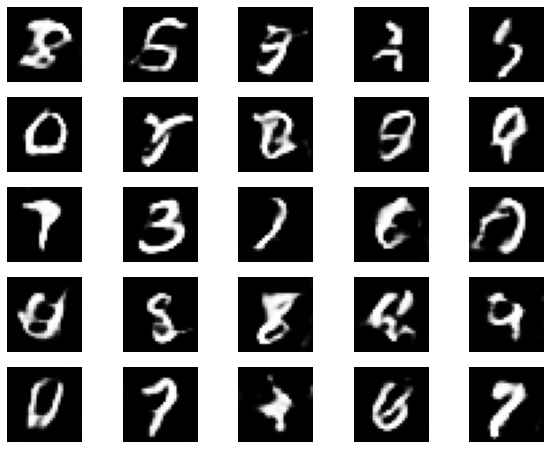

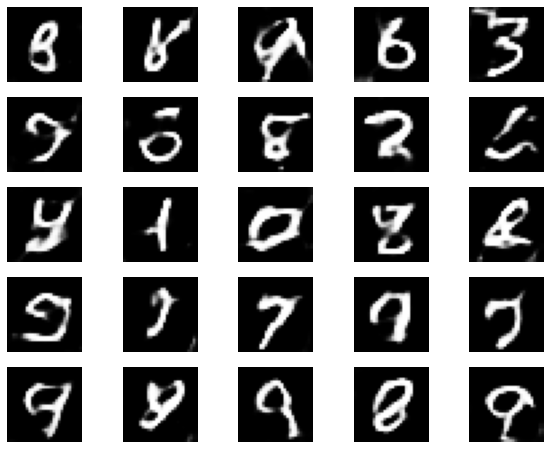

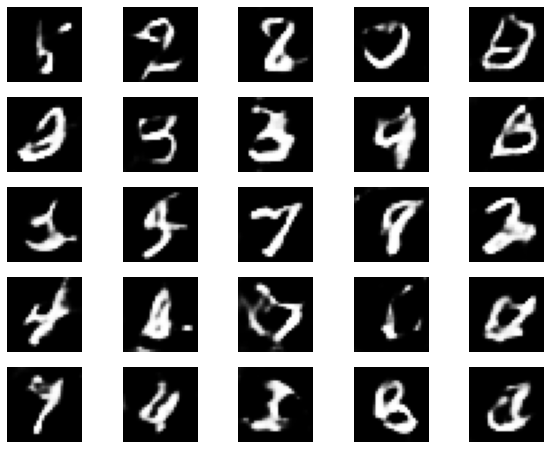

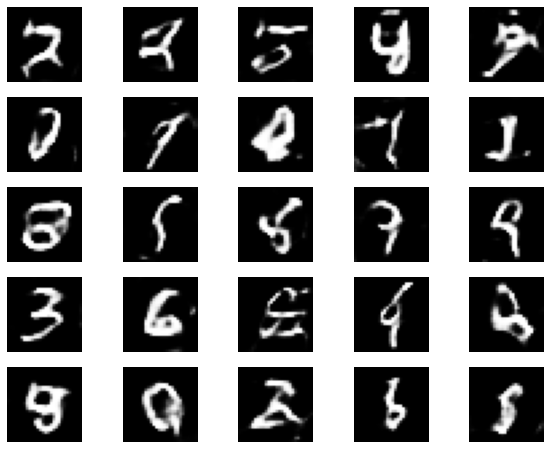

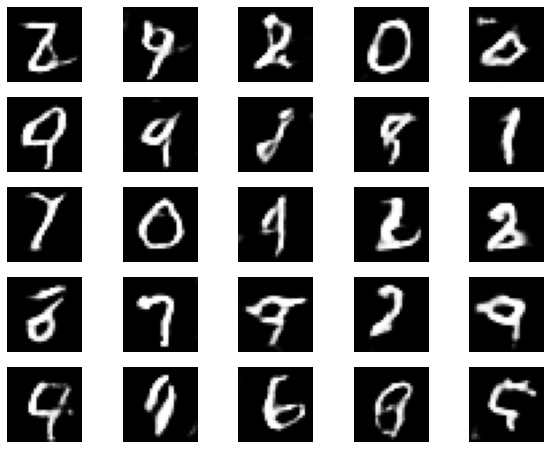

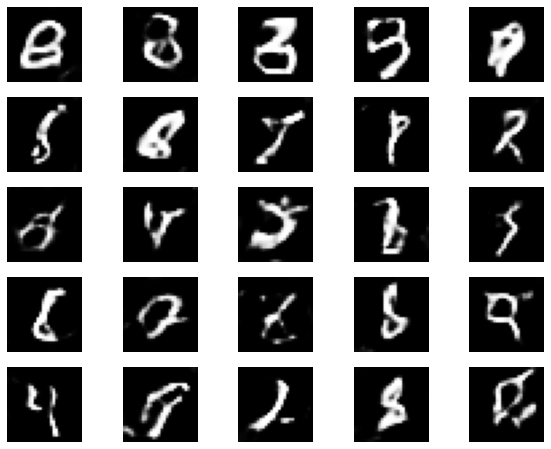

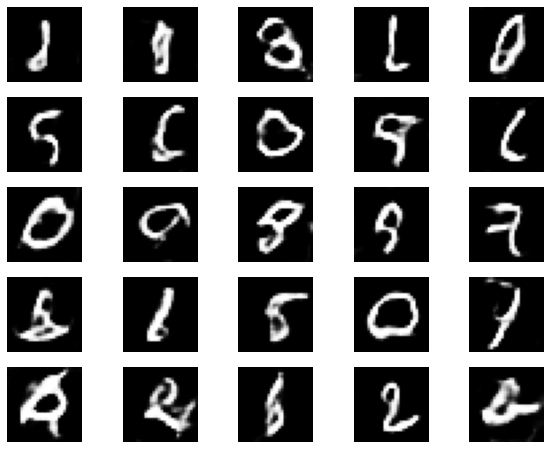

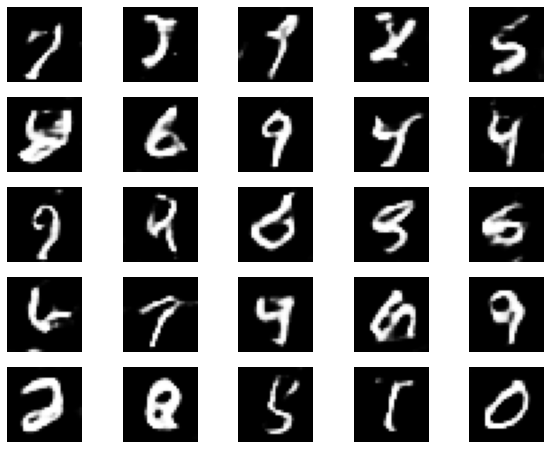

In [27]:
for i in range(2000):
    # 실제 데이터를 판별자에 입력하는 부분
    idx = np.random.randint(0, X_train.shape[0],32)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)
    
    # 가상 이미지를 판별자에 입력하는 부분
    noise = np.random.normal(0,1,(32,100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    
    # 판별자와 생성자의 오차를 계산한다.
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gen.train_on_batch(noise, true)
    
    print(f'epoch : {i}, d_loss : {d_loss}, g_loss : {g_loss}')
    
    # 이미지를 중간에 생성해본다.
    if i % 200 == 0:
        # 가중치가 업데이트된 생성자를 통해 이미지를 생성한다.
        noise = np.random.normal(0,1,(25,100))
        gen_imgs = generator.predict(noise)
        
        # 이미지 사이즈 조정
        gen_imgs = 0.5* gen_imgs + 0.5
        
        # 5 x 5짜리 그래프 영역을 생성한다.
        fig, axs = plt.subplots(5,5)
        
        count = 0
        for j in range(5):
            for k in range(5):
                # 그래프 그리기
                axs[j,k].imshow(gen_imgs[count, :, :,0], cmap='gray')
                axs[j,k].axis('off')
                count += 1
        # 파일로 저장
        fig.savefig(f'gan_image/gan_mnist_{i}.png')